In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from functools import partial
import torchvision
from tqdm import trange, tqdm
import os 
import glob
import time
import copy
import random
from PIL import Image, ImageOps, ImageFilter

os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device('cpu')

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
import sys
sys.path.append('../')

In [4]:
import re
import pandas as pd
import einops
from os.path import join
from tqdm import trange, tqdm
from os.path import join
from edm_utils import parse_train_logfile
from dataset_utils import onehot2attr_tsr
from stats_plot_utils import estimate_CI, shaded_error
from rule_utils import get_rule_list, get_obj_list, get_rule_img, check_consistent

In [9]:
figdir = "../Figures"

In [5]:
!ls /n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/

base_cifar10_20240130-2317
base_cifar10_20240130-2318
base_gabor_prime_20240130-2251
base_gabor_sf_20240130-2306
base_mnist_20240129-1342
base_mnist_20240129-1406
base_mnist_20240130-2207
base_RAVEN10_20240131-2049
base_RAVEN10_abstract_20240201-0036
base_RAVEN10_abstract_onehot_20240201-0147
BigBlnrlrsm_RAVEN10_abstract_onehot_20240209-1411
BigBlnr_RAVEN10_abstract_20240208-1709
BigBlnr_RAVEN10_abstract_onehot_20240209-0208
Big_RAVEN10_abstract_20240207-1925
Big_RAVEN10_abstract_onehot_20240207-1925
WideBlnr_RAVEN10_abstract_20240211-1747
WideBlnr_RAVEN10_abstract_onehot_20240211-1743
Wide_RAVEN10_abstract_20240206-2323
Wide_RAVEN10_abstract_onehot_20240206-2324


In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)

### Synopsis function

In [6]:
def batch_load_samples_infer_rules(samples_dir, epoch_list, encoding="onehot"):
    rules_all = []
    for epoch in tqdm(epoch_list): 
        if not os.path.exists(join(samples_dir, 'tensor_'+str(epoch)+'.pt')):
            print(epoch, "not exist")
            break
        samples = torch.load(join(samples_dir, 'tensor_'+str(epoch)+'.pt')) # (batch, 27, 9, 9)
        if encoding == "onehot":
            attr_tsr_list = onehot2attr_tsr(samples, threshold=0.5)
        elif encoding == "digit":
            attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
        else:
            raise ValueError("encoding should be onehot or digit")
        rules_list = []
        for i, attr_tsr in enumerate(attr_tsr_list): 
            rule_img = get_rule_img(attr_tsr) # (3, 9, 9) -> (3,)
            rules_list.append(rule_img)
        rules_all.append(rules_list)
    rules_all = np.asarray(rules_all) # (201, 25, 3)
    epoch_list = epoch_list[:len(rules_all)]
    
    consistent_mat = []
    for epoch_i in trange(len(rules_all)): 
        consistent_all = [check_consistent(rules) 
                          for rules in rules_all[epoch_i]]
        consistent_mat.append(consistent_all)
    consistent_mat = np.asarray(consistent_mat)
    return rules_all, consistent_mat, epoch_list

In [7]:
def visualize_consistency(epoch_list, consistent_mat, title_str="Wide Dep x3 Blnr", figname="RAVEN10_abstract_BigBlnr", figdir="../Figures", ):
    sample_size = consistent_mat.shape[1]
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI((consistent_mat == 1).sum(axis=1), sample_size, alpha=0.05)
    shaded_error(plt.gca(), epoch_list, (consistent_mat == 1).mean(axis=1),
                    CI_low, CI_high, label="Same in 3 rows", color="C0")
    CI_low, CI_high = estimate_CI((consistent_mat == 2).sum(axis=1), sample_size, alpha=0.05)
    shaded_error(plt.gca(), epoch_list, (consistent_mat==2).mean(axis=1),
                    CI_low, CI_high, label="Same in 2 rows", color="C1")
    ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}, uncond Diffusion")
    ax.legend()
    fig.savefig(join(figdir,f"{figname}_rule_consistency.pdf"), dpi=300, )#bbox_inches='tight')
    fig.savefig(join(figdir,f"{figname}_rule_consistency.png"), dpi=300, )#bbox_inches='tight')
    return fig
    
def visualize_rule_validity(epoch_list, rules_all, title_str="Wide Dep x3 Blnr", figname="RAVEN10_abstract_BigBlnr", figdir="../Figures", ):
    sample_size = rules_all.shape[1]
    row_num = rules_all.shape[2]
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI((rules_all != -1).sum(axis=(1,2)), sample_size * row_num, alpha=0.05)
    shaded_error(plt.gca(), epoch_list, (rules_all != -1).mean(axis=(1,2)),
                    CI_low, CI_high, label="valid row", color="C2")
    ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}, uncond Diffusion")
    ax.legend()
    fig.savefig(join(figdir,f"{figname}_rule_valid.pdf"), dpi=300, )#bbox_inches='tight')
    fig.savefig(join(figdir,f"{figname}_rule_valid.png"), dpi=300, )#bbox_inches='tight')
    return fig

In [8]:
epoch_list = list(np.arange(0, 100000, 500))
epoch_list.append(99999)

### One-hot encoding model (Base)

                timestamp level   step  learning_rate  average_loss  batch_loss
996   2024-02-01 02:49:45  INFO  99600         0.0002      0.328226    0.197677
997   2024-02-01 02:49:48  INFO  99700         0.0002      0.328127    0.198251
998   2024-02-01 02:49:52  INFO  99800         0.0002      0.328028    0.222092
999   2024-02-01 02:49:55  INFO  99900         0.0002      0.327931    0.231565
1000  2024-02-01 02:49:59  INFO  99999         0.0002      0.327830    0.215114


<Axes: xlabel='step'>

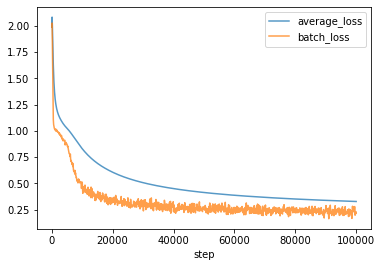

In [17]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/base_RAVEN10_abstract_onehot_20240201-0147"
df = parse_train_logfile(join(expdir, "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [18]:
epoch_list = list(np.arange(0, 100000, 500))+[99999]
rules_all_oht, consistent_mat_oht, epoch_list = batch_load_samples_infer_rules(
    join(expdir, "samples"), epoch_list, encoding="onehot")
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_oht, 
         rules_all=rules_all_oht, epoch_list=epoch_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 10072.10it/s]


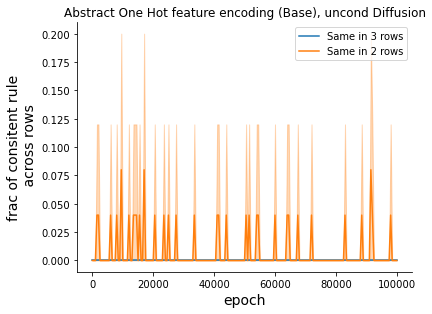

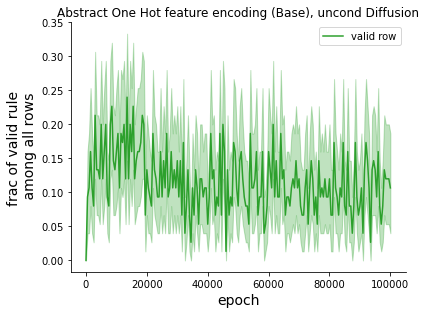

In [19]:
visualize_consistency(epoch_list, consistent_mat_oht, 
                      title_str="Abstract One Hot feature encoding (Base)", 
                      figname="RAVEN10_abstract_onehot_base",)
visualize_rule_validity(epoch_list, rules_all_oht, 
                        title_str="Abstract One Hot feature encoding (Base)", 
                        figname="RAVEN10_abstract_onehot_base",);

### Digit feature encoding model (Base)

                timestamp level   step  learning_rate  average_loss  \
996   2024-02-01 01:37:50  INFO  99600         0.0002      0.874396   
997   2024-02-01 01:37:54  INFO  99700         0.0002      0.874347   
998   2024-02-01 01:37:57  INFO  99800         0.0002      0.874292   
999   2024-02-01 01:38:01  INFO  99900         0.0002      0.874254   
1000  2024-02-01 01:38:04  INFO  99999         0.0002      0.874195   

      batch_loss  
996     0.746673  
997     0.742360  
998     0.780893  
999     0.824455  
1000    0.758389  


<Axes: xlabel='step'>

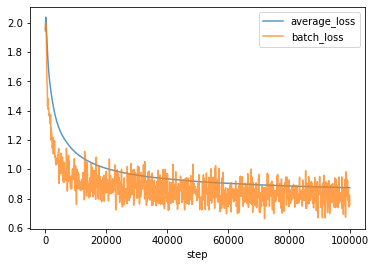

In [12]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/base_RAVEN10_abstract_20240201-0036"
df = parse_train_logfile(join(expdir, "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [14]:
epoch_list = list(np.arange(0, 100000, 500))+[99999]
rules_all, consistent_mat, epoch_list = batch_load_samples_infer_rules(
    join(expdir, "samples"), epoch_list, encoding="digit")
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat, 
         rules_all=rules_all, epoch_list=epoch_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 9118.55it/s]


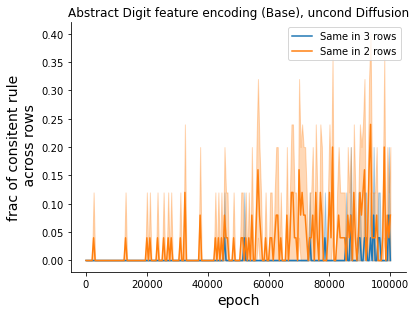

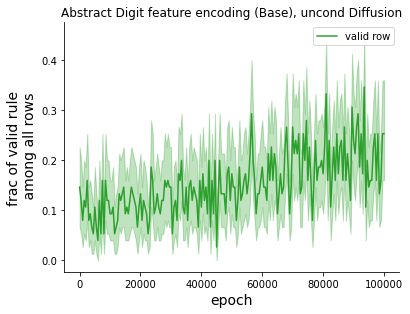

In [15]:
visualize_consistency(epoch_list, consistent_mat, 
                      title_str="Abstract Digit feature encoding (Base)", 
                      figname="RAVEN10_abstract_base",)
visualize_rule_validity(epoch_list, rules_all, 
                        title_str="Abstract Digit feature encoding (Base)", 
                        figname="RAVEN10_abstract_base",);

### Base model (Base)

In [20]:
exproot = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/"
!ls /n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/

BaseBlnr_RAVEN10_abstract_20240212-2142
BaseBlnr_RAVEN10_abstract_onehot_20240212-2143
base_cifar10_20240130-2317
base_cifar10_20240130-2318
base_gabor_prime_20240130-2251
base_gabor_sf_20240130-2306
base_mnist_20240129-1342
base_mnist_20240129-1406
base_mnist_20240130-2207
base_RAVEN10_20240131-2049
base_RAVEN10_abstract_20240201-0036
Base_RAVEN10_abstract_20240212-2139
base_RAVEN10_abstract_onehot_20240201-0147
Base_RAVEN10_abstract_onehot_20240212-2140
BigBlnrlrsm_RAVEN10_abstract_onehot_20240209-1411
BigBlnr_RAVEN10_abstract_20240208-1709
BigBlnr_RAVEN10_abstract_onehot_20240209-0208
Big_RAVEN10_abstract_20240207-1925
Big_RAVEN10_abstract_onehot_20240207-1925
WideBlnr_RAVEN10_abstract_20240211-1747
WideBlnr_RAVEN10_abstract_onehot_20240211-1743
Wide_RAVEN10_abstract_20240206-2323
Wide_RAVEN10_abstract_onehot_20240206-2324


In [22]:
join(exproot, expname)

'/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Base_RAVEN10_abstract_20240212-2139'

In [23]:
!ls /n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Base_RAVEN10_abstract_20240212-2139/samples

tensor_0.pt	  tensor_325000.pt  tensor_55000.pt   tensor_775500.pt
tensor_100000.pt  tensor_32500.pt   tensor_5500.pt    tensor_776000.pt
tensor_10000.pt   tensor_325500.pt  tensor_550500.pt  tensor_776500.pt
tensor_1000.pt	  tensor_326000.pt  tensor_551000.pt  tensor_777000.pt
tensor_100500.pt  tensor_326500.pt  tensor_551500.pt  tensor_777500.pt
tensor_101000.pt  tensor_327000.pt  tensor_552000.pt  tensor_778000.pt
tensor_101500.pt  tensor_327500.pt  tensor_552500.pt  tensor_778500.pt
tensor_102000.pt  tensor_328000.pt  tensor_553000.pt  tensor_779000.pt
tensor_102500.pt  tensor_328500.pt  tensor_553500.pt  tensor_779500.pt
tensor_103000.pt  tensor_329000.pt  tensor_554000.pt  tensor_780000.pt
tensor_103500.pt  tensor_329500.pt  tensor_554500.pt  tensor_78000.pt
tensor_104000.pt  tensor_330000.pt  tensor_555000.pt  tensor_780500.pt
tensor_104500.pt  tensor_33000.pt   tensor_55500.pt   tensor_781000.pt
tensor_105000.pt  tensor_330500.pt  tensor_555500.pt  tensor_781500.pt
tensor_10500

                 timestamp level    step  learning_rate  average_loss  batch_loss
9996   2024-02-13 07:51:27  INFO  999600         0.0002      0.796984    0.838021
9997   2024-02-13 07:51:30  INFO  999700         0.0002      0.796981    0.722801
9998   2024-02-13 07:51:34  INFO  999800         0.0002      0.796980    0.801322
9999   2024-02-13 07:51:37  INFO  999900         0.0002      0.796978    0.736317
10000  2024-02-13 07:51:41  INFO  999999         0.0002      0.796976    0.809345


 10%|█████████▊                                                                                        | 20/201 [00:01<00:09, 19.01it/s]


100000 not exist


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 18897.52it/s]


ValueError: x and y must have same first dimension, but have shapes (20,) and (201,)

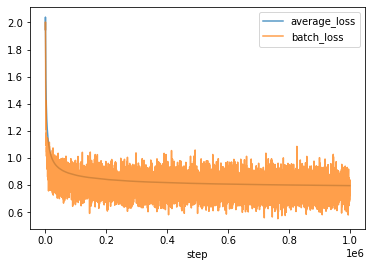

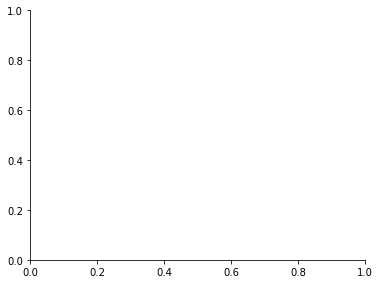

In [21]:
for expname in ["Base_RAVEN10_abstract_20240212-2139",
                "Base_RAVEN10_abstract_onehot_20240212-2140",
                "BaseBlnr_RAVEN10_abstract_20240212-2142",
                "BaseBlnr_RAVEN10_abstract_onehot_20240212-2143",]:
    expdir = join(exproot, expname)
    df = parse_train_logfile(join(expdir, "std.log"))
    df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)
    encoding = "onehot" if "onehot" in expname else "digit"
    expprefix = expname.split("_")[0]
    epoch_list = list(np.arange(0, 1000000, 5000))+[999999]
    rules_all, consistent_mat, epoch_list = batch_load_samples_infer_rules(
        join(expdir, "samples"), epoch_list, encoding=encoding)
    np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
            consistent_mat=consistent_mat, 
            rules_all=rules_all, epoch_list=epoch_list)
    figname = f"RAVEN10_abstract{'_onehot' if encoding=='onehot' else ''}_{expprefix}"
    visualize_consistency(epoch_list, consistent_mat, 
                      title_str=f"Abstract One Hot feature encoding ({expname})", 
                      figname=figname,)
    visualize_rule_validity(epoch_list, rules_all, 
                            title_str=f"Abstract One Hot feature encoding ({expname})", 
                            figname=figname,);

In [ ]:
epoch_list = list(np.arange(0, 100000, 500))+[99999]
rules_all_oht, consistent_mat_oht, epoch_list = batch_load_samples_infer_rules(
    join(expdir, "samples"), epoch_list, encoding="onehot")
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_oht, 
         rules_all=rules_all_oht, epoch_list=epoch_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 10072.10it/s]


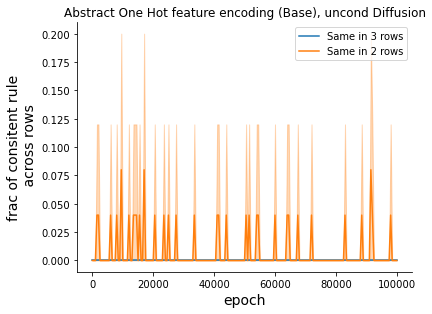

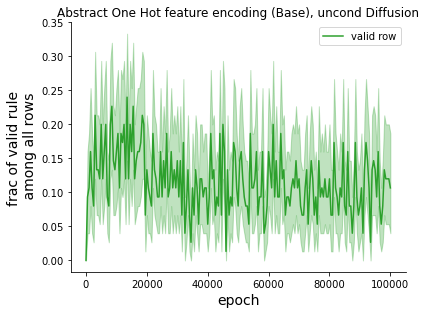

In [ ]:
visualize_consistency(epoch_list, consistent_mat_oht, 
                      title_str="Abstract One Hot feature encoding (Base)", 
                      figname="RAVEN10_abstract_onehot_base",)
visualize_rule_validity(epoch_list, rules_all_oht, 
                        title_str="Abstract One Hot feature encoding (Base)", 
                        figname="RAVEN10_abstract_onehot_base",);

### Digit feature encoding model (Wide)

In [180]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_20240206-2323/samples"
epoch_list = list(np.arange(0, 1000000, 5000))
rules_all_digit_wide = []
for epoch in tqdm(epoch_list): 
    if not os.path.exists(expdir+'/tensor_'+str(epoch)+'.pt'):
        print(epoch, "not exist")
        break
    samples = torch.load(expdir+'/tensor_'+str(epoch)+'.pt') # (batch, 3, 9, 9)
    attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
    rules_list = []
    for i, attr_tsr in enumerate(attr_tsr_list): 
        rule_img = get_rule_img(attr_tsr) # (3, 9, 9) -> (3,)
        rules_list.append(rule_img)
    rules_all_digit_wide.append(rules_list)
rules_all_digit_wide = np.asarray(rules_all_digit_wide) # (201, 25, 3)

consistent_mat_wide = []
for epoch_i in trange(len(rules_all_digit_wide)): 
    rules_all = rules_all_digit_wide[epoch_i]
    consistent_all = [check_consistent(rules) for rules in rules_all]
    consistent_mat_wide.append(consistent_all)
consistent_mat_wide = np.asarray(consistent_mat_wide)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.55it/s]


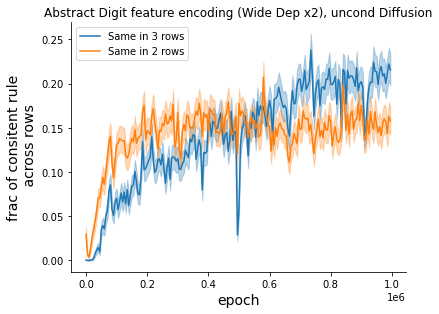

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
epoch_list = epoch_list[:len(consistent_mat_wide)]
CI_low, CI_high = estimate_CI((consistent_mat_wide == 1).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_wide == 1).mean(axis=1),
                CI_low, CI_high, label="Same in 3 rows", color="C0")
CI_low, CI_high = estimate_CI((consistent_mat_wide == 2).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_wide==2).mean(axis=1),
                CI_low, CI_high, label="Same in 2 rows", color="C1")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_consistency.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_consistency.png", dpi=300, )#bbox_inches='tight')

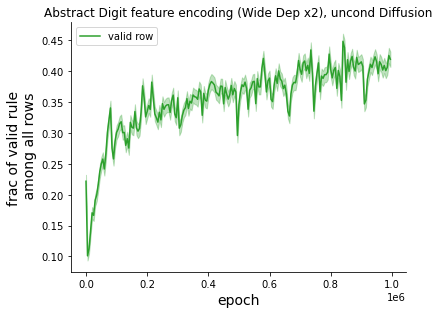

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
epoch_list = epoch_list[:len(consistent_mat_wide)]
CI_low, CI_high = estimate_CI((rules_all_digit_wide != -1).sum(axis=(1,2)), 2048 * 3, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (rules_all_digit_wide != -1).mean(axis=(1,2)),
                CI_low, CI_high, label="valid row", color="C2")
ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.png", dpi=300, )#bbox_inches='tight')

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-06 23:24:33  INFO     0       0.000000      1.933217    1.933217
1  2024-02-06 23:24:41  INFO   100       0.000004      2.040321    2.044233
2  2024-02-06 23:24:47  INFO   200       0.000008      1.974165    1.897349
3  2024-02-06 23:24:52  INFO   300       0.000012      1.907248    1.712826
4  2024-02-06 23:24:58  INFO   400       0.000016      1.838222    1.622334


<Axes: xlabel='step'>

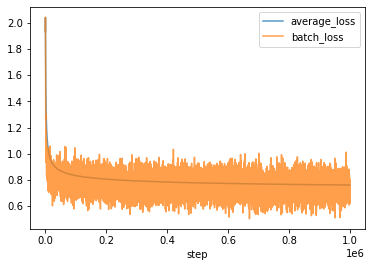

In [190]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_20240206-2323/samples"
df = parse_train_logfile(join(expdir, "..", "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [192]:
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_wide, 
         rules_all=rules_all_digit_wide,
         epoch_list=epoch_list)

#### Obsolete plots

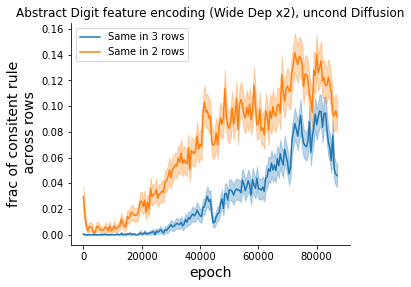

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((consistent_mat_wide == 1).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list[:len(consistent_mat_wide)], (consistent_mat_wide == 1).mean(axis=1),
                CI_low, CI_high, label="Same in 3 rows", color="C0")
CI_low, CI_high = estimate_CI((consistent_mat_wide == 2).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list[:len(consistent_mat_wide)], (consistent_mat_wide==2).mean(axis=1),
                CI_low, CI_high, label="Same in 2 rows", color="C1")
# ax.plot(epoch_list[:len(consistent_mat_wide)], 
#   (consistent_mat_wide == 1).mean(axis=(1)), alpha=0.5, label="same rule 3 rows")
# ax.plot(epoch_list[:len(consistent_mat_wide)], 
#   (consistent_mat_wide == 2).mean(axis=(1)), alpha=0.5, label="same rule 2 rows")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_consistency.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_consistency.png", dpi=300, )#bbox_inches='tight')

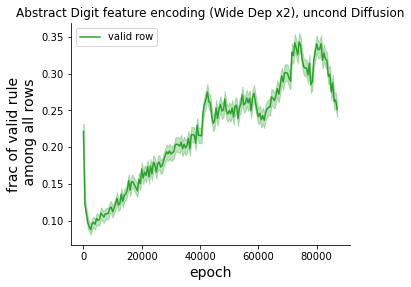

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((rules_all_digit_wide != -1).sum(axis=(1,2)), 2048 * 3, alpha=0.05)
shaded_error(plt.gca(), epoch_list[:len(consistent_mat_wide)], (rules_all_digit_wide != -1).mean(axis=(1,2)),
                CI_low, CI_high, label="valid row", color="C2")
ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.png", dpi=300, )#bbox_inches='tight')

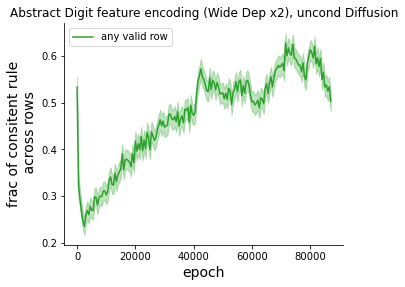

In [142]:

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((consistent_mat_wide != 0).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list[:len(consistent_mat_wide)], (consistent_mat_wide != 0).mean(axis=1),
                CI_low, CI_high, label="any valid row", color="C2")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.png", dpi=300, )#bbox_inches='tight')

### One-hot encoding model, (Wide)

In [28]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_onehot_20240206-2324/samples"
epoch_list = list(np.arange(0, 1000000, 5000))
rules_all_onehot_wide = []
for epoch in tqdm(epoch_list): 
    if not os.path.exists(expdir+'/tensor_'+str(epoch)+'.pt'):
        print(epoch, "not exist")
        break
    samples = torch.load(expdir+'/tensor_'+str(epoch)+'.pt') # (batch, 27, 9, 9)
    attr_tsr_list = onehot2attr_tsr(samples, threshold=0.5)
    # attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
    rules_list = []
    for i, attr_tsr in enumerate(attr_tsr_list): 
        rule_img = get_rule_img(attr_tsr) # (3, 9, 9) -> (3,)
        rules_list.append(rule_img)
    rules_all_onehot_wide.append(rules_list)
rules_all_onehot_wide = np.asarray(rules_all_onehot_wide) # (201, 25, 3)

consistent_mat_onehot_wide = []
for epoch_i in trange(len(rules_all_onehot_wide)): 
    rules_all = rules_all_onehot_wide[epoch_i]
    consistent_all = [check_consistent(rules) for rules in rules_all]
    consistent_mat_onehot_wide.append(consistent_all)
consistent_mat_onehot_wide = np.asarray(consistent_mat_onehot_wide)

  2%|██▍                                                                                                | 5/200 [00:10<07:09,  2.20s/it]

  2%|██▍                                                                                                | 5/200 [00:11<07:41,  2.37s/it]


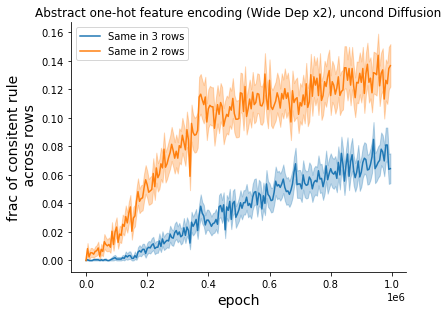

In [187]:
epoch_list = list(np.arange(0, 1000000, 5000))[:len(consistent_mat_onehot_wide)]
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((consistent_mat_onehot_wide == 1).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_onehot_wide == 1).mean(axis=1),
                CI_low, CI_high, label="Same in 3 rows", color="C0")
CI_low, CI_high = estimate_CI((consistent_mat_onehot_wide == 2).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_onehot_wide==2).mean(axis=1),
                CI_low, CI_high, label="Same in 2 rows", color="C1")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract one-hot feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_onehot_Wide_rule_consistency.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_onehot_Wide_rule_consistency.png", dpi=300, )#bbox_inches='tight')

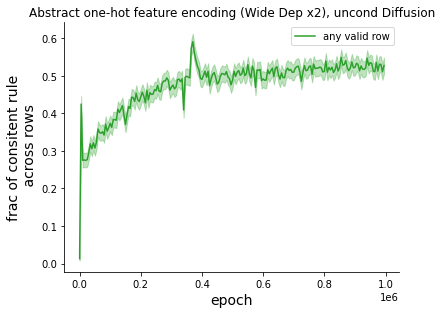

In [188]:
epoch_list = list(np.arange(0, 1000000, 5000))[:len(consistent_mat_onehot_wide)]
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((consistent_mat_onehot_wide != 0).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_onehot_wide != 0).mean(axis=1),
                CI_low, CI_high, label="any valid row", color="C2")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract one-hot feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_onehot_Wide_rule_valid.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_onehot_Wide_rule_valid.png", dpi=300, )#bbox_inches='tight')

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-06 23:24:47  INFO     0       0.000000      1.991650    1.991650
1  2024-02-06 23:24:56  INFO   100       0.000004      2.072678    1.998352
2  2024-02-06 23:25:01  INFO   200       0.000008      1.895700    1.505616
3  2024-02-06 23:25:07  INFO   300       0.000012      1.716550    1.215978
4  2024-02-06 23:25:12  INFO   400       0.000016      1.571327    1.094095


<Axes: xlabel='step'>

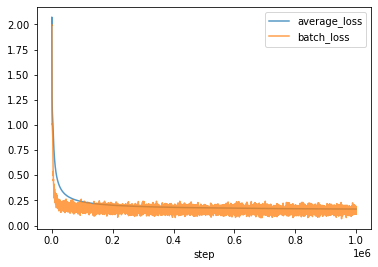

In [194]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_onehot_20240206-2324/samples"
df = parse_train_logfile(join(expdir, "..", "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [195]:
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_onehot_wide, 
         rules_all=rules_all_onehot_wide,
         epoch_list=epoch_list)

### Digit encoding model (Wide Blinear)

In [20]:
figdir = "../Figures"

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-11 17:48:35  INFO     0       0.000000      1.933218    1.933218
1  2024-02-11 17:48:52  INFO   100       0.000004      2.040091    2.043183
2  2024-02-11 17:48:58  INFO   200       0.000008      1.973816    1.897806
3  2024-02-11 17:49:05  INFO   300       0.000012      1.907617    1.711666
4  2024-02-11 17:49:11  INFO   400       0.000016      1.838851    1.626607


<Axes: xlabel='step'>

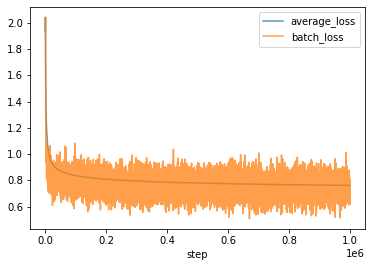

In [21]:
# WideBlnr_RAVEN10_abstract_onehot_20240211-1743
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnr_RAVEN10_abstract_20240211-1747"
df = parse_train_logfile(join(expdir, "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [22]:
epoch_list = list(np.arange(0, 1000000, 5000))
rules_all_wide, consistent_mat_wide, epoch_list = batch_load_samples_infer_rules(
    join(expdir, "samples"), epoch_list, encoding="digit")
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_wide, 
         rules_all=rules_all_wide, epoch_list=epoch_list)

  0%|                                                                                                           | 0/200 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.38it/s]


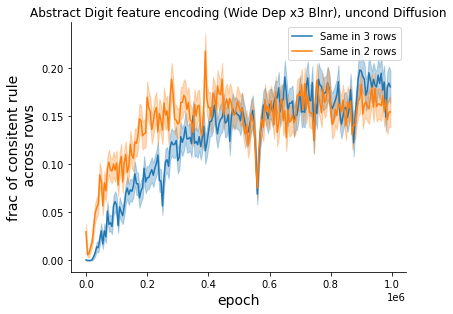

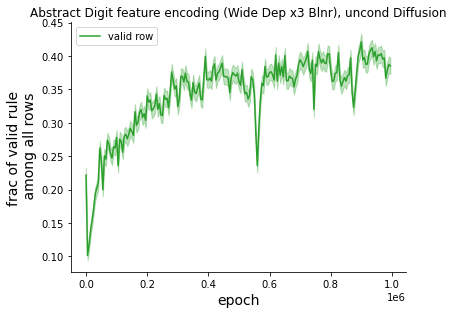

In [23]:
visualize_consistency(epoch_list, consistent_mat_wide, 
                      title_str="Abstract Digit feature encoding (Wide Dep x3 Blnr)", 
                      figname="RAVEN10_abstract_BigBlnr",)
visualize_rule_validity(epoch_list, rules_all_wide, 
                        title_str="Abstract Digit feature encoding (Wide Dep x3 Blnr)", 
                        figname="RAVEN10_abstract_BigBlnr",);

### Onehot encoding model (Wide Blinear)

In [24]:
figdir = "../Figures"

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-11 17:44:06  INFO     0       0.000000      1.991650    1.991650
1  2024-02-11 17:44:23  INFO   100       0.000004      2.071867    1.993694
2  2024-02-11 17:44:30  INFO   200       0.000008      1.889596    1.490114
3  2024-02-11 17:44:36  INFO   300       0.000012      1.717754    1.305027
4  2024-02-11 17:44:42  INFO   400       0.000016      1.581664    1.105420


<Axes: xlabel='step'>

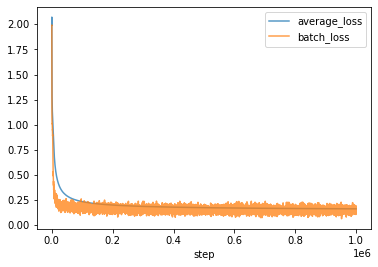

In [25]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnr_RAVEN10_abstract_onehot_20240211-1743"
df = parse_train_logfile(join(expdir, "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [26]:
epoch_list = list(np.arange(0, 1000000, 5000))
rules_all_wide_oh, consistent_mat_wide_oh, epoch_list = batch_load_samples_infer_rules(
    join(expdir, "samples"), epoch_list, encoding="onehot")
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_wide_oh, 
         rules_all=rules_all_wide_oh, epoch_list=epoch_list)

  4%|███▍                                                                                               | 7/200 [00:15<07:08,  2.22s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 95.83it/s]


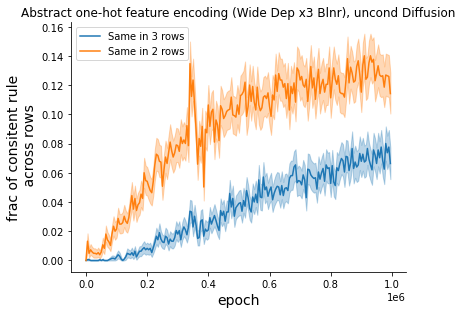

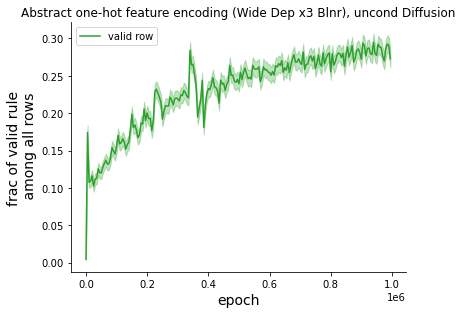

In [27]:
visualize_consistency(epoch_list, consistent_mat_wide_oh, 
                      title_str="Abstract one-hot feature encoding (Wide Dep x3 Blnr)", 
                      figname="RAVEN10_abstract_onehot_BigBlnr",)
visualize_rule_validity(epoch_list, rules_all_wide_oh, 
                        title_str="Abstract one-hot feature encoding (Wide Dep x3 Blnr)", 
                        figname="RAVEN10_abstract_onehot_BigBlnr",);

### Digit encoding model (Big)

In [47]:
figdir = "../Figures"

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-08 17:10:20  INFO     0       0.000000      1.975290    1.975290
1  2024-02-08 17:10:50  INFO   100       0.000004      2.010045    2.079594
2  2024-02-08 17:11:01  INFO   200       0.000008      1.938682    1.747530
3  2024-02-08 17:11:13  INFO   300       0.000012      1.858422    1.703774
4  2024-02-08 17:11:24  INFO   400       0.000016      1.783291    1.563127


<Axes: xlabel='step'>

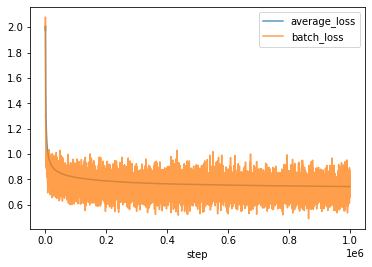

In [52]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/BigBlnr_RAVEN10_abstract_20240208-1709"
df = parse_train_logfile(join(expdir, "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [54]:
epoch_list = list(np.arange(0, 1000000, 500))
rules_all_big, consistent_mat_big, epoch_list = batch_load_samples_infer_rules(
    join(expdir, "samples"), epoch_list, encoding="digit")
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_big, 
         rules_all=rules_all_big, epoch_list=epoch_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 90.53it/s]


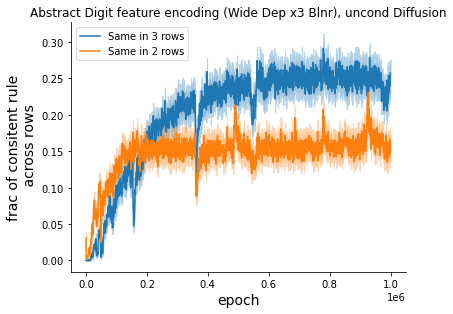

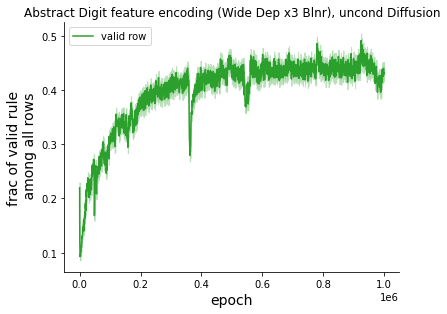

In [55]:
visualize_consistency(epoch_list, consistent_mat_big, 
                      title_str="Abstract Digit feature encoding (Wide Dep x3 Blnr)", 
                      figname="RAVEN10_abstract_BigBlnr",)
visualize_rule_validity(epoch_list, rules_all_big, 
                        title_str="Abstract Digit feature encoding (Wide Dep x3 Blnr)", 
                        figname="RAVEN10_abstract_BigBlnr",);

### One-hot encoding model (Big) (smaller lr bilinear)

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-09 14:11:47  INFO     0       0.000000      1.988933    1.988933
1  2024-02-09 14:12:17  INFO   100       0.000002      2.064577    2.114632
2  2024-02-09 14:12:28  INFO   200       0.000004      1.931527    1.568207
3  2024-02-09 14:12:39  INFO   300       0.000006      1.768501    1.387501
4  2024-02-09 14:12:50  INFO   400       0.000008      1.634294    1.153785


<Axes: xlabel='step'>

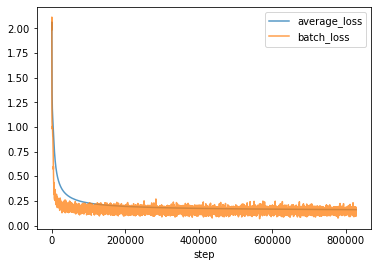

In [57]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/BigBlnrlrsm_RAVEN10_abstract_onehot_20240209-1411"
df = parse_train_logfile(join(expdir, "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [58]:
epoch_list = list(np.arange(0, 1000000, 5000))
rules_all_big_onehot, consistent_mat_big_onehot, epoch_list = batch_load_samples_infer_rules(
    join(expdir, "samples"), epoch_list, encoding="onehot")
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_big_onehot, 
         rules_all=rules_all_big_onehot, epoch_list=epoch_list)

 84%|████████████████████████████████████████████████████████████████████████████████▉                | 167/200 [06:02<01:11,  2.17s/it]


835000 not exist


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 95.64it/s]


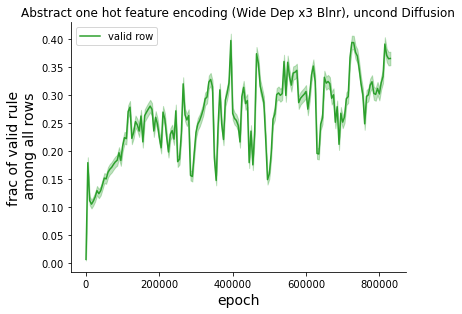

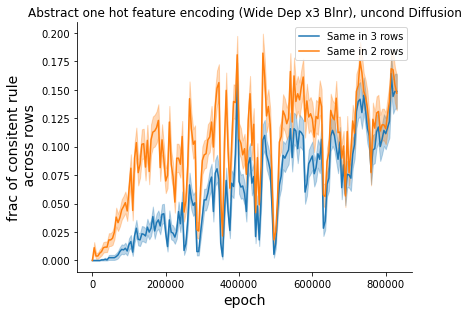

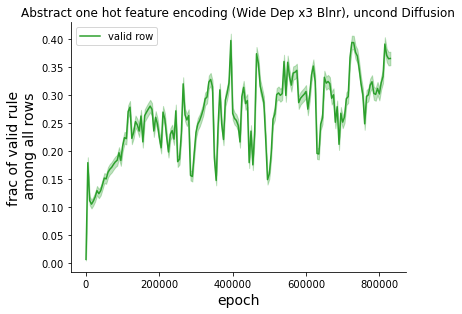

In [59]:
visualize_consistency(epoch_list, consistent_mat_big_onehot, 
                      title_str="Abstract one hot feature encoding (Wide Dep x3 Blnr)", 
                      figname="RAVEN10_abstract_onehot_BigBlnrlrsm",)
visualize_rule_validity(epoch_list, rules_all_big_onehot, 
                        title_str="Abstract one hot feature encoding (Wide Dep x3 Blnr)", 
                        figname="RAVEN10_abstract_onehot_BigBlnrlrsm",)

### One-hot encoding model (Big) (crashed in middle)

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-08 17:11:23  INFO     0       0.000000      1.988933    1.988933
1  2024-02-08 17:11:53  INFO   100       0.000004      2.025911    1.968148
2  2024-02-08 17:12:04  INFO   200       0.000008      1.799392    1.351388
3  2024-02-08 17:12:16  INFO   300       0.000012      1.609467    1.133062
4  2024-02-08 17:12:27  INFO   400       0.000016      1.474099    1.048590


<Axes: xlabel='step'>

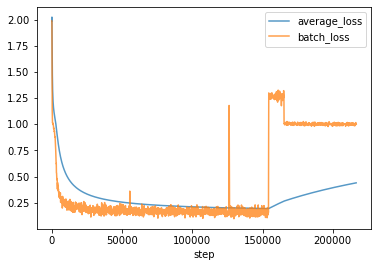

In [51]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/BigBlnr_RAVEN10_abstract_onehot_20240208-1710"
df = parse_train_logfile(join(expdir, "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [36]:
epoch_list = list(np.arange(0, 1000000, 5000))
rules_all_big_onehot, consistent_mat_big_onehot, epoch_list = batch_load_samples_infer_rules(
    join(expdir, "samples"), epoch_list, encoding="onehot")
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_big_onehot, 
         rules_all=rules_all_big_onehot, epoch_list=epoch_list)

  0%|                                                                                                           | 0/200 [00:00<?, ?it/s]

 22%|█████████████████████                                                                             | 43/200 [01:31<05:33,  2.12s/it]


215000 not exist


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 114.14it/s]


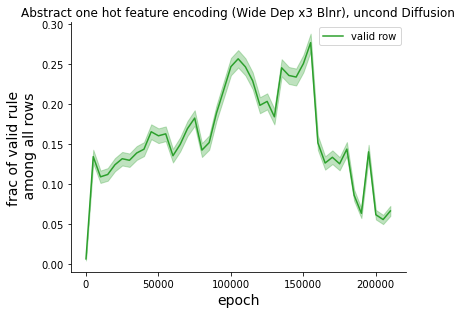

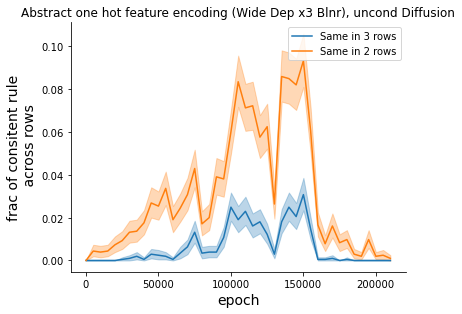

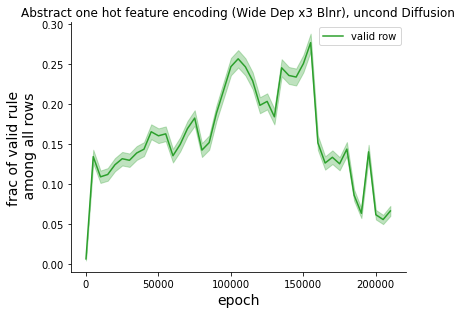

In [39]:
visualize_consistency(epoch_list, consistent_mat_big_onehot, 
                      title_str="Abstract one hot feature encoding (Wide Dep x3 Blnr)", 
                      figname="RAVEN10_abstract_onehot_BigBlnr",)
visualize_rule_validity(epoch_list, rules_all_big_onehot, 
                        title_str="Abstract one hot feature encoding (Wide Dep x3 Blnr)", 
                        figname="RAVEN10_abstract_onehot_BigBlnr",)

### Sanity Check: Infer rule on training set

In [ ]:
def load_PGM_abstract(attr): 
    """attr: (3, 9, 3), (num_panel, num_pos, num_attr)"""
    attr = attr.to(int)
    attr = torch.cat(tuple(attr.view(3, 3, 3, 3)), dim=1) # [3, 3, 3, 3] -> [3, 9, 3]
    inputs = attr.permute(2, 0, 1) # num_attr, num_row=3, num_col (n panel x 3)
    return inputs 

In [20]:
d_PGM = torch.load('PGM_shape_size_color_normalized.pt') 
train_inputs = torch.load('train_inputs.pt') # [35, 10000, 3, 9, 3]
print(train_inputs.shape)

torch.Size([35, 10000, 3, 9, 3])


In [28]:
load_PGM_abstract(train_inputs[0, 0]).shape

torch.Size([3, 3, 9])

In [55]:
mtg = torch.cat([load_PGM_abstract(train_inputs[5, 2]),
                 load_PGM_abstract(train_inputs[2, 0]),
                 load_PGM_abstract(train_inputs[33, 6]),], dim=1)
get_rule_img(mtg)

array([ 7,  4, -1])

In [63]:
failed_cnt = 0
for class_id in range(35):
    sample_id = random.choice(range(10000))
    infer_rule_id = get_rule_img(load_PGM_abstract(train_inputs[class_id, sample_id]))
    print(class_id, infer_rule_id[0], "infer failed " if infer_rule_id[0] == -1 else "")
    failed_cnt += (infer_rule_id[0] == -1)

print(failed_cnt, "failed inference")

0 1 
1 3 
2 4 
3 -1 infer failed 
4 -1 infer failed 
5 7 
6 -1 infer failed 
7 9 
8 10 
9 11 
10 12 
11 14 
12 -1 infer failed 
13 -1 infer failed 
14 17 
15 -1 infer failed 
16 19 
17 21 
18 22 
19 23 
20 24 
21 -1 infer failed 
22 -1 infer failed 
23 27 
24 -1 infer failed 
25 29 
26 30 
27 31 
28 32 
29 33 
30 34 
31 -1 infer failed 
32 -1 infer failed 
33 33 
34 39 
11 failed inference


In [178]:
failed_cnt = 0
failed_total = 0
inconsistent_cnt = 0
batchsize = 100
for class_id in range(35):
    sample_ids = np.random.randint(0, 10000, batchsize)
    mtg = torch.cat([load_PGM_abstract(train_inputs[class_id, sample_id]) for sample_id in sample_ids], dim=1)
    infer_rule_id = get_rule_img(mtg)
    is_inconsistent = (len(np.unique(infer_rule_id)) > 1)
    # print("gt", class_id, "infer", infer_rule_id, )
    failed_cnt += (infer_rule_id == -1).any()
    failed_total += (infer_rule_id == -1).sum()
    inconsistent_cnt += is_inconsistent

failed_ratio = failed_total / (35 * batchsize)
print(f"Over 35 classes, each with {batchsize} samples,")
print(failed_cnt, "failed inference", )
print(f"failed ratio {failed_ratio:.3f} ({failed_total} / {35 * batchsize})")
print(inconsistent_cnt, "inconsistent inference (different infered rule from the same class.)")

Over 35 classes, each with 100 samples,
31 failed inference
failed ratio 0.352 (1231 / 3500)
30 inconsistent inference (different infered rule from the same class.)


In [75]:
failed_cnt = 0
inconsistent_cnt = 0
for class_id in range(35):
    sample_ids = np.random.randint(0, 10000, 10)
    mtg = torch.cat([load_PGM_abstract(train_inputs[class_id, sample_id]) for sample_id in sample_ids], dim=1)
    infer_rule_id = get_rule_img(mtg)
    print("gt", class_id, "infer", infer_rule_id, )
    failed_cnt += (infer_rule_id == -1).any()
    inconsistent_cnt += (len(np.unique(infer_rule_id)) > 1)

print(failed_cnt, "failed inference")
print(inconsistent_cnt, "inconsistent inference")

gt 0 infer [1 1 1 1 1 1 1 1 1 1]
gt 1 infer [3 3 3 3 3 3 3 3 3 3]
gt 2 infer [4 4 4 4 4 4 4 4 4 4]
gt 3 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 4 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 5 infer [7 7 7 7 7 7 7 7 7 7]
gt 6 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 7 infer [ 9  9  9  9  9  9  9  9  9 -1]
gt 8 infer [10 10 10 -1 10 10 10 10 10 10]
gt 9 infer [11 11 11 11 11 11 11 11 11 11]
gt 10 infer [12 12 12 12 12 12 -1 12 12 12]
gt 11 infer [14 14 14 14 14 14 14 14 14 14]
gt 12 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 13 infer [-1 -1  7 -1 -1 -1 -1 -1 -1 -1]
gt 14 infer [17 17 17 17 17 17 17 17 17 17]
gt 15 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 16 infer [19 19 19 19 19 19 19 19 19 19]
gt 17 infer [21 21 21 21 21 21 21 21 21 21]
gt 18 infer [22 -1 22 22 22 22 -1 22 22 22]
gt 19 infer [23 23 23 23 23 23 23 23 -1 23]
gt 20 infer [24 24 24 24 24 24 24 24 24 24]
gt 21 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 22 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 23 infer [27 27 27 27 27 27 27 27 2